In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt

tf.set_random_seed(777)

#Min Max Normalization
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [3]:
pwd

'/Users/stories2/Documents/GitHub/Flask-server'

In [5]:
ls -l ./Tests

total 344
-rw-r--r--  1 stories2  staff  165623 Aug  1 16:26 bitcoin_ticker_eth_krw_hour.csv
-rw-r--r--  1 stories2  staff    4412 Aug  1 16:31 rnn-stock-prediction.ipynb


In [6]:
# train Parameters
seq_length = 7
data_dim = 6
hidden_dim = 10
output_dim = 1
learning_rate = 0.01

# bid ask low high volume
xy = np.genfromtxt('./Tests/bitcoin_ticker_eth_krw_hour.csv', delimiter=',', dtype=np.str)[:,[4,7,8,9,10,11]]
print(xy[0])

xy = xy[1:].astype(np.float)
xy = MinMaxScaler(xy[1:]) #normalize
x = xy[:]
y = xy[:,[0]]
print(x[:2])
print(y[:2])

['last' 'bid' 'ask' 'low' 'high' 'volume']
[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
 [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]]
[[ 0.52493075]
 [ 0.59141274]]


In [7]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next last price
    if i < 2 : print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
 [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
 [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
 [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
 [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
 [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
 [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]] -> [ 0.48268698]
[[ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
 [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
 [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
 [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
 [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
 [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]
 [ 0.48

In [8]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:len(dataY)])

print(trainX[:2])
print(trainY[:2])

[[[ 0.52493075  0.37053353  0.52463567  0.60770975  0.54615385  0.32157781]
  [ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
  [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
  [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
  [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
  [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
  [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]]

 [[ 0.59141274  0.41752325  0.59333796  0.60770975  0.52820513  0.32015694]
  [ 0.55817175  0.39402839  0.57321305  0.60770975  0.52820513  0.32937215]
  [ 0.60249307  0.39255996  0.59750173  0.60770975  0.52820513  0.33856945]
  [ 0.50069252  0.35340186  0.50104094  0.60770975  0.52820513  0.34429369]
  [ 0.51385042  0.35829662  0.50728661  0.60770975  0.52820513  0.35179124]
  [ 0.47368421  0.33431229  0.48507981  0.60770975  0.51623932  0.34650965]
  [ 0.4826

In [9]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
# outputs[:, -1] : all batch of data_dim of last seq_length
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

[step: 0] loss: 339.6351013183594
[step: 1] loss: 147.8060760498047
[step: 2] loss: 43.96809387207031
[step: 3] loss: 4.8833184242248535
[step: 4] loss: 7.362371921539307
[step: 5] loss: 27.404855728149414
[step: 6] loss: 44.140167236328125
[step: 7] loss: 49.23305892944336
[step: 8] loss: 44.13612365722656
[step: 9] loss: 33.338172912597656
[step: 10] loss: 21.170717239379883
[step: 11] loss: 10.860898971557617
[step: 12] loss: 4.362303256988525
[step: 13] loss: 2.3717429637908936
[step: 14] loss: 4.318700313568115
[step: 15] loss: 8.350320816040039
[step: 16] loss: 12.057479858398438
[step: 17] loss: 13.890363693237305
[step: 18] loss: 13.580594062805176
[step: 19] loss: 11.688453674316406
[step: 20] loss: 9.057976722717285
[step: 21] loss: 6.4552507400512695
[step: 22] loss: 4.398677349090576
[step: 23] loss: 3.1261823177337646


[step: 24] loss: 2.640333890914917
[step: 25] loss: 2.784273147583008
[step: 26] loss: 3.3199493885040283
[step: 27] loss: 3.9950618743896484
[step: 28] loss: 4.593746662139893
[step: 29] loss: 4.968806743621826
[step: 30] loss: 5.054976463317871
[step: 31] loss: 4.864077568054199
[step: 32] loss: 4.466331481933594
[step: 33] loss: 3.963874101638794
[step: 34] loss: 3.46295166015625
[step: 35] loss: 3.0509228706359863
[step: 36] loss: 2.781545877456665
[step: 37] loss: 2.669959783554077
[step: 38] loss: 2.6965742111206055
[step: 39] loss: 2.817318916320801
[step: 40] loss: 2.9770047664642334
[step: 41] loss: 3.1227223873138428
[step: 42] loss: 3.214246988296509
[step: 43] loss: 3.230350971221924


[step: 44] loss: 3.1700668334960938
[step: 45] loss: 3.049607038497925
[step: 46] loss: 2.8962111473083496
[step: 47] loss: 2.7404849529266357
[step: 48] loss: 2.6092257499694824
[step: 49] loss: 2.5198307037353516
[step: 50] loss: 2.4777283668518066
[step: 51] loss: 2.4766929149627686
[step: 52] loss: 2.501945972442627
[step: 53] loss: 2.534839153289795
[step: 54] loss: 2.557969093322754
[step: 55] loss: 2.559283494949341
[step: 56] loss: 2.534325122833252
[step: 57] loss: 2.486248731613159
[step: 58] loss: 2.423877716064453
[step: 59] loss: 2.358532428741455
[step: 60] loss: 2.3006951808929443
[step: 61] loss: 2.257333517074585
[step: 62] loss: 2.230552911758423
[step: 63] loss: 2.2177910804748535
[step: 64] loss: 2.213168144226074
[step: 65] loss: 2.209625244140625
[step: 66] loss: 2.2010138034820557
[step: 67] loss: 2.183680534362793
[step: 68] loss: 2.1571099758148193
[step: 69] loss: 2.123613119125366
[step: 70] loss: 2.087226152420044


[step: 71] loss: 2.05228328704834
[step: 72] loss: 2.0220746994018555
[step: 73] loss: 1.9980149269104004
[step: 74] loss: 1.979488730430603
[step: 75] loss: 1.9643317461013794
[step: 76] loss: 1.9497404098510742
[step: 77] loss: 1.9332690238952637
[step: 78] loss: 1.9135373830795288
[step: 79] loss: 1.8905601501464844
[step: 80] loss: 1.865518569946289
[step: 81] loss: 1.8401812314987183
[step: 82] loss: 1.8162552118301392
[step: 83] loss: 1.7947845458984375
[step: 84] loss: 1.7758939266204834
[step: 85] loss: 1.7588833570480347
[step: 86] loss: 1.7425854206085205
[step: 87] loss: 1.7258447408676147
[step: 88] loss: 1.7079285383224487
[step: 89] loss: 1.6887362003326416
[step: 90] loss: 1.668716549873352
[step: 91] loss: 1.6486467123031616
[step: 92] loss: 1.6292792558670044
[step: 93] loss: 1.611057996749878
[step: 94] loss: 1.5940190553665161
[step: 95] loss: 1.5778048038482666


[step: 96] loss: 1.5619049072265625
[step: 97] loss: 1.5458471775054932
[step: 98] loss: 1.5294189453125
[step: 99] loss: 1.5126839876174927
[step: 100] loss: 1.4959392547607422
[step: 101] loss: 1.4795336723327637
[step: 102] loss: 1.4637339115142822
[step: 103] loss: 1.4486043453216553
[step: 104] loss: 1.4340102672576904
[step: 105] loss: 1.4197214841842651
[step: 106] loss: 1.4054946899414062
[step: 107] loss: 1.3911936283111572
[step: 108] loss: 1.3768450021743774
[step: 109] loss: 1.362586259841919
[step: 110] loss: 1.3485811948776245
[step: 111] loss: 1.3349571228027344
[step: 112] loss: 1.3217418193817139
[step: 113] loss: 1.3088563680648804
[step: 114] loss: 1.2961971759796143
[step: 115] loss: 1.283656358718872
[step: 116] loss: 1.2711999416351318
[step: 117] loss: 1.2588608264923096
[step: 118] loss: 1.2467074394226074
[step: 119] loss: 1.2348138093948364
[step: 120] loss: 1.2232139110565186
[step: 121] loss: 1.211876630783081
[step: 122] loss: 1.2007485628128052
[step: 123]

[step: 124] loss: 1.1789084672927856
[step: 125] loss: 1.1681666374206543
[step: 126] loss: 1.15758216381073
[step: 127] loss: 1.147188425064087
[step: 128] loss: 1.1370104551315308
[step: 129] loss: 1.127034306526184
[step: 130] loss: 1.1172395944595337
[step: 131] loss: 1.1075917482376099
[step: 132] loss: 1.0980792045593262
[step: 133] loss: 1.0887017250061035
[step: 134] loss: 1.07947838306427
[step: 135] loss: 1.0704247951507568
[step: 136] loss: 1.0615400075912476
[step: 137] loss: 1.0528180599212646
[step: 138] loss: 1.0442408323287964
[step: 139] loss: 1.0357904434204102
[step: 140] loss: 1.0274604558944702
[step: 141] loss: 1.0192564725875854
[step: 142] loss: 1.011186122894287
[step: 143] loss: 1.003257155418396
[step: 144] loss: 0.9954695701599121
[step: 145] loss: 0.98781418800354
[step: 146] loss: 0.980283796787262
[step: 147] loss: 0.9728682041168213
[step: 148] loss: 0.9655713438987732
[step: 149] loss: 0.9583962559700012
[step: 150] loss: 0.9513466358184814
[step: 151] 


[step: 152] loss: 0.9376108646392822
[step: 153] loss: 0.9309120178222656
[step: 154] loss: 0.9243217706680298
[step: 155] loss: 0.917838990688324
[step: 156] loss: 0.9114661812782288
[step: 157] loss: 0.9052039980888367
[step: 158] loss: 0.899055540561676
[step: 159] loss: 0.8930124640464783
[step: 160] loss: 0.8870744705200195
[step: 161] loss: 0.8812416791915894
[step: 162] loss: 0.8755155205726624
[step: 163] loss: 0.8698895573616028
[step: 164] loss: 0.8643714785575867
[step: 165] loss: 0.8589538931846619
[step: 166] loss: 0.853639543056488
[step: 167] loss: 0.8484257459640503
[step: 168] loss: 0.8433084487915039
[step: 169] loss: 0.838291347026825
[step: 170] loss: 0.8333749771118164
[step: 171] loss: 0.8285571932792664
[step: 172] loss: 0.8238356709480286
[step: 173] loss: 0.8192160725593567
[step: 174] loss: 0.8146907091140747
[step: 175] loss: 0.8102601170539856
[step: 176] loss: 0.8059288859367371
[step: 177] loss: 0.8016946315765381
[step: 178] loss: 0.7975566387176514
[ste


[step: 180] loss: 0.7895606160163879
[step: 181] loss: 0.7857045531272888
[step: 182] loss: 0.7819366455078125
[step: 183] loss: 0.7782660126686096
[step: 184] loss: 0.774684727191925
[step: 185] loss: 0.771194577217102
[step: 186] loss: 0.7677964568138123
[step: 187] loss: 0.7644849419593811
[step: 188] loss: 0.7612635493278503
[step: 189] loss: 0.7581294178962708
[step: 190] loss: 0.7550823092460632
[step: 191] loss: 0.7521200180053711
[step: 192] loss: 0.7492431998252869
[step: 193] loss: 0.7464470267295837
[step: 194] loss: 0.7437337040901184
[step: 195] loss: 0.7411015033721924
[step: 196] loss: 0.7385479211807251
[step: 197] loss: 0.7360718250274658
[step: 198] loss: 0.7336714267730713
[step: 199] loss: 0.7313480973243713


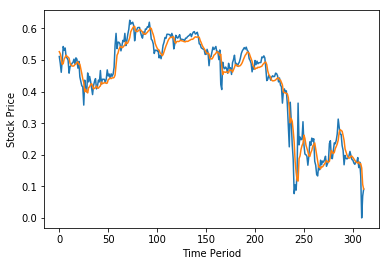

In [10]:
# train Parameters
iterations = 200

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))
#         print(sess.run(outputs[:, -1], feed_dict={X: trainX, Y: trainY}))
        
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()